<a href="https://colab.research.google.com/github/sehan25/ESAA-2022-2/blob/main/Assignment/0905-Handson-ch03-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CHAPTER 3. 분류**

## **3.1 MNIST**

- MNIST 데이터셋: 고등학생과 미국 인구조사국 직원들이 손으로 쓴 70,000개의 작은 숫자 이미지를 모은 데이터셋
- 사이킷런에서 제공하는 여러 헬퍼 함수를 사용해 잘 알려진 데이터셋을 내려받을 수 있음.

In [1]:
import numpy as np

In [2]:
# MNIST 데이터셋 내려받기
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

- 사이킷런에서 읽어 들인 데이터셋들은 일반적으로 비슷한 딕셔너리 구조를 가짐.
    - 데이터셋을 설명하는 DESCR 키
    - 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data 키
    - 레이블 배열을 담은 target 키

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

&rarr; 이미지가 70,000개 있고 각 이미지에는 784개의 특성이 있음.  
&rarr; 이미지가 28*28 픽셀이기 때문.

- 개개의 특성은 단순히 0(흰색)부터 255(검은색)까지의 픽셀 강도를 나타냄.

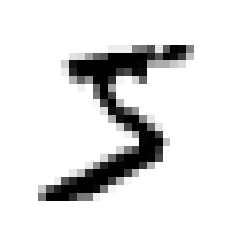

In [5]:
# 데이터셋에서 이미지 하나 확인하기
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [6]:
# 실제 레이블 확인
y[0]

'5'

- 대부분 머신러닝 알고리즘은 숫자를 기대하므로 문자열인 y를 정수로 변환

In [7]:
y = y.astype(np.uint8)

- 데이터를 자세히 조사하기 전에 항상 테스트 세트를 만들고 따로 떼어놓아야 함.
- MNIST 데이터셋은 이미 훈련 세트(앞쪽 60,000개 이미지)와 테스트 세트(뒤쪽 10,000개 이미지)로 나누어놓음.

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

- 훈련 세트는 이미 섞여 있어서 모든 교차 검증 폴드를 비슷하게 만듦.
- 어떤 학습 알고리즘은 훈련 샘플의 순서에 민감해서 많은 비슷한 샘플이 연이어 나타나면 성능이 나빠짐. 데이터셋을 섞으면 이런 문제를 방지 가능함.

## **3.2 이진 분류기 훈련**

*문제를 단순화해서 하나의 숫자, 예를 들면 숫자 5만 식별해보기*
- '5-감지기'는 '5'와 '5 아님' 두 개의 클래스를 구분할 수 있는 이진 분류기의 한 예
- 분류 작업을 위해 타깃 벡터 만들어보기



In [9]:
# 분류 작업을 위해 타깃 벡터 만들어보기
y_train_5 = (y_train == 5) # 5는 True고, 다른 숫자는 모두 False
y_test_5 = (y_test == 5)

- 분류 모델을 하나 선택해서 훈련시키기
    - 사이킷런의 SGDClassifier 클래스를 사용해 확률적 경사 하강법(SGD) 분류기로 시작해보는 것도 나쁘지 않음.
        - 이 분류기는 매우 큰 데이터셋을 효율적으로 처리하는 장점을 지니고 있음. SGD가 한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문.

In [10]:
# SGDClassifier 모델을 만들고 전체 훈련 세트 사용해 훈련시키기
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

- 모델을 사용해 숫자 5의 이미지 감지해보기

In [11]:
# 숫자 5의 이미지 감지해보기
sgd_clf.predict([some_digit])

array([ True])

 &rarr; 이미지가 5를 나타낸다고 추측함. 이 경우엔 특별하게 정확히 맞춘 듯함.

## **3.3 성능 측정**

### 3.3.1 교차 검증을 사용한 정확도 측정
- 교차 검증은 모델을 평가하는 좋은 방법

<U>교차 검증 구현</U>
- 가끔 사이킷런이 제공하는 기능보다 교차 검증 과정을 더 많이 제어해야 할 필요가 있음. 이 때는 교차 검증 기능을 직접 구현하면 됨.
- 다음 코드는 사이킷런의 `cross_val_scroe()` 함수와 거의같은 작업 수행하고 동일한 결과 출력함.

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


- StratifiedKFold는 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링을 수행함.
    - 매 반복에서 분류기 객체를 복제하여 훈련 폴드를 훈련시키고 테스트 폴드로 예측을 만든 다음, 올바른 예측의 수를 세어 정확한 예측의 비율을 출력함.

- `cross_val_score()` 함수로 폴드가 3개인 k-겹 교차 검증을 사용해 SGDClassifier 모델을 평가
    - k-겹 교차 검증은 훈련 세트를 k개(여기서는 3개)의 폴드로 나누고, 각 폴드에 대해 예측을 만들고 평가하기 위해 나머지 폴드로 훈련시킨 모델을 사용한다는 것을 기억해야 함.

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

 &rarr; 모든 교차 검증 폴드에 대해 정확도가 95% 이상임.
 - 모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기를 만들어 비교해보기


In [14]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

 &rarr; 정확도가 90% 이상으로 나옴. 이미지의 10% 정도만 숫자 5이기 때문에 무조건 '5 아님'으로 예측하면 정확히 맞출 확률이 90%인 것임.

- 이 예제는 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여줌. 특히 **불균형한 데이터셋**을 다룰 때(즉, 어떤 클래스가 다른 것보다 월등히 많은 경우) 더욱 그러함.

### 3.3.2 오차 행렬
- 분류기의 성능을 평가하는 더 좋은 방법은 **오차 행렬**을 조사하는 것
- 오차 행렬을 만들려면 실제 타깃과 비교할 수 있도록 먼저 예측값을 만들어야 함.
- 테스트 세트로 예측을 만들 수 있지만 여기서 사용하면 안 됨.(테스트 세트는 분류기가 출시 준비를 마치고 나서 프로젝트의 맨 마지막에 사용된다는 것을 기억). 대신 `cross_val_predict()` 함수를 사용 가능함.

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

- `cross_val_predict()` 함수는 `cross_val_score()` 함수처럼 k-겹 교차 검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환함.  
    - 즉, 훈련 세트의 모든 샘플에 대해 깨끗한 예측을 얻게 됨.(= 모델이 훈련하는 동안 보지 못했던 데이터에 대해 예측했다는 의미)
- `confusion_matrix()` 함수를 사용해 오차 행렬을 만들 준비 되었으니, 타깃 클래스(y_train_5)와 예측 클래스(y_train_pred)를 넣고 호출하면 됨.

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

- 오차 행렬의 행은 실제 클래스를 나타내고 열은 예측한 클래스를 나타냄.

 &rarr; 첫 번째 행: '5 아님' 이미지에 대한 것(음성 클래스(negative class))  
 &rarr; 두 번째 행: '5' 이미지에 대한 것(양성 클래스(positive class))
    - true negative: 53,892개
    - false positive: 687개
    - false negative: 1,891개
    - true positive: 3,530개

- 완벽한 분류기라면 진짜 양성과 진짜 음성만 가지고 있을 것이므로 오차 행렬의 주대각선(왼쪽 위에서 오른쪽 아래로)만 0이 아닌 값이 됨.

In [18]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

- 오차 행렬이 많은 정보를 제공해주지만 가끔 더 요약된 지표가 필요할 때도 있음.
- **정밀도(precision)**: 양성 예측의 정확도
$$precision = \frac{TP}{TP + FP}$$
    - TP: 진짜 양성의 수
    - FP: 거짓 양성의 수
- 확실한 양성 샘플 하나만 예측하면 간단히 완벽한 정밀도를 얻을 수 있지만(정밀도=1/1=100%), 이는 분류기가 다른 양성 샘플을 무시하기 때문에 그리 유용하지 않음.
- 정밀도는 재현율이라는 또 다른 지표와 같이 사용하는 것이 일반적임.
- **재현율(recall)**: 분류기가 정확하게 감지한 양성 샘플의 비율, 민감도(sensitivity) 또는 진짜 양성 비율(true positive)이라고도 함.
$$recall = \frac{TP}{TP + FN}$$
    - FN: 거짓 음성의 수


### 3.3.3 정밀도와 재현율
- 사이킷런은 정밀도와 재현율을 포함하여 분류기의 지표를 계산하는 여러 함수를 제공함.

In [19]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [20]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

 &rarr; 5로 판별된 이미지 중 83.7%만 정확하며, 전체 숫자 5에서 65.1%만 감지함.
- 정밀도와 재현율을 F1 점수(F1 score)라고 하는 하나의 숫자로 만들면 편리할 때가 많음. 특히 두 분류기를 비교할 때 그러함.
- **F1 점수(F1 score)**: 정밀도와 재현율의 조화 평균(harmonic mean)

$$F1 = \frac{2}{\frac{1}{recall}+\frac{1}{precision}} = 2* \frac{precision * recall}{precision + recall} = \frac{TP}{TP + \frac{FN + FP}{2}}$$

In [21]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

- 정밀도와 재현율이 비슷한 분류기에서는 F1 점수가 높음. 하지만 이게 항상 바람직한 것은 아님.
- 상황에 따라 정밀도가 중요할 수도 있고 재현율이 중요할 수도 있음.
- 정밀도를 올리면 재현율이 줄고 그 반대도 마찬가지임. - **정밀도/재현율 트레이드오프**

### 3.3.4 정밀도/재현율 트레이드오프

- SGDClassifier가 분류를 어떻게 결정하는지 살펴보며 이 트레이드오프 이해해보기
    - 이 분류기는 결정 함수를 사용하여 각 샘플의 점수를 계산함. 이 점수가 임곗값보다 크면 샘플을 양성 클래스에 할당하고 그렇지 않으면 음성 캘릇에 할당함.
    - 임곗값을 높이면 정밀도가 높아지고 재현율이 낮아지며, 임곗값을 내리면 재현율인 높아지고 정밀도가 줄어듦.
- 사이킷런에서 임곗값을 직접 지정할 수는 없지만 예측에 사용한 점수는 확인할 수 있음.
    - 분류기의 `predict()` 메서드 대신 `decision_function()` 메서드를 호출하면 각 샘플의 점수를 얻을 수 있음.
    - 이 점수를 기반으로 원하는 임곗값을 정해 예측을 만들 수 있음.

In [22]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [23]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

 &rarr; SGDClassifier의 임곗값이 0이므로 위 코드는 `predict()` 메서드와 같은 결과(즉, True)를 반환함.

In [24]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

 &rarr; 임곗값을 높이면 재현율이 줄어든다는 것을 보여줌. 이미지가 실제로 숫자 5이고 임곗값이 0일 때는 분류기가 이를 감지했지만, 임곗갑승ㄹ 8,000으로 높이면 이를 놓치게 됨.

<U>적절한 임곗값 정하기</U>
- `cross_val_predict()` 함수를 사용해 훈련 세트에 있는 모든 샘플의 점수를 구해야 함.
- 하지만 이번에는 예측 결과가 아니라 결정 점수를 반환하도록 지정해야 함.

In [25]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

- 이 점수로 `precision_recall_curve()` 함수를 사용하여 가능한 몯느 임곗값에 대해 정밀도와 재현율을 계산할 수 있음.

In [26]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

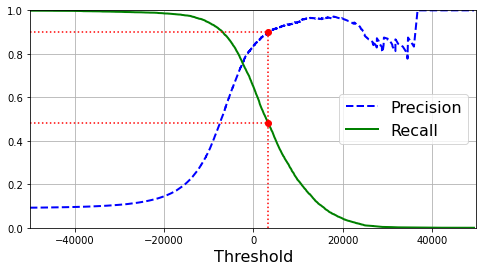

In [27]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8,4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0.,0.9], "r:")
plt.plot([-50000, threshold_90_precision], [0.9,0.9], "r:")
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")      

plt.show()

- 좋은 정밀도/재현율 트레이드오프를 선택하는 다른 방법은 재현율에 대한 정밀도 곡선을 그리는 것임.

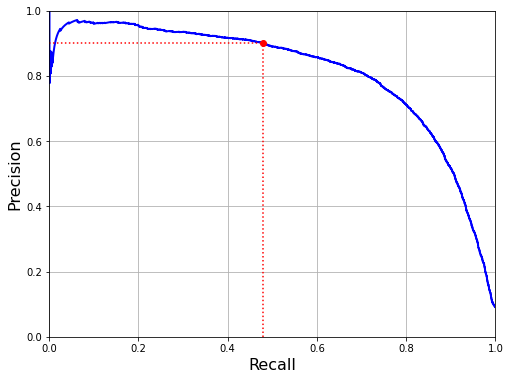

In [28]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8,6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0.,0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9,0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")

plt.show()

 &rarr; 재현율 80% 근처에서 정밀도가 급격하게 줄어들기 시작함. 이 하강점 직전을 정밀도/재현율 트레이드오프로 선택하는 것이 좋음.
 
정밀도 90%를 달성하는 것을 목표로 가정해보기
- 그래프에서 임곗값이 약 8,000 정도라는 것을 알 수 있는데, 조금 더 정확하게 최소한 90% 정밀도가 되는 가장 낮은 임곗값을 찾을 수 있음.

In [29]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

- (훈련 세트에 대한) 예측을 만들려면 분류기의 `predict()` 메서드를 호출하는 대신 다음 코드를 실행함.

In [30]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

- 예측에 대한 정밀도와 재현율 확인

In [31]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [32]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### 3.3.5 ROC 곡선
- 수신기 조작 특성(receiver operating characterisitic(ROC)) 곡선도 이진 분류에서 널리 사용하는 도구임.
- 정밀도/재현율 곡선과 매우 비슷하지만, 정밀도에 대한 재현율 곡선이 아니고 거짓 양성 비율(false positive rate(FPR))에 대한 진짜 양성 비율(true positive rate(TPR))의 곡선임.
- 양성으로 잘못 분류된 음성 샘플의 비율이 FPR인데, 이는 1에서 음성으로 정확하게 분류한 음성 샘플의 비율인 진짜 음성 비율(true negative rate(TNR))을 뺀 값임.
- TNR을 특이도라고도 함.
- **ROC 곡선**: 민감도(재현율)에 대한 1-특이도 그래프
- ROC 곡선을 그리려면 먼저 `roc_curve()` 함수를 사용해 여러 임곗값에서 TPR과 FPR을 계산해야 함.

In [33]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

- 맷플롯립을 사용해 TPR에 대한 FPR 곡선을 나타낼 수 있음.

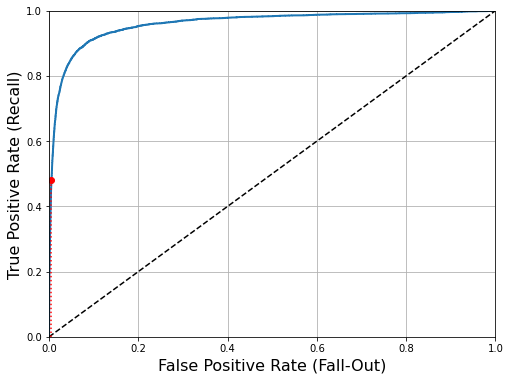

In [34]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8,6))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")

plt.show()

 &rarr; 여기에서도 트레이드오프가 있음. 재현율(TPR)이 높을수록 분류기가 만드는 거짓 양성(FPR)이 늘어남.
 &rarr; 점선은 완전한 랜덤 분류기의 ROC 곡선을 뜻함. 좋은 분류기는 이 점선에서 최대한 멀리 떨어져 있어야 함(왼쪽 위 모서리).

- 곡선 아래의 면적(AUC)을 측정하면 분류기들을 비교할 수 있음.
- 완벽한 분류기는 ROC의 AUC가 1이고, 완전한 랜덤 분류기는 0.5임.

In [41]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

> ROC 곡선이 정밀도/재현율(PR) 곡선과 비슷해서 어떤 것을 사용해야 할지 궁금할 수 있음.  
일반적인 법칙은 양성 클래스가 드물거나 거짓 양성이 더 중요할 때 PR 곡선을 사용하고 그렇지 않으면 ROC 곡선을 사용함.

RandomForestClassifier를 훈련시켜 SGDClassifier의 ROC 곡선과 ROC AUC 점수를 비교해보기
- 훈련 세트의 샘플에 대한 점수를 얻어야 함.
    - 작동 방식의 차이 때문에 RandomForestClassifier에는 `decision_function()` 메서드가 없는 대신,` predict_proba()` 메서드가 있음.
        - `predict_proba()` 메서드는 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환함.
    - 사이킷런 분류기는 일반적으로 이 두 메서드 중 하나 또는 둘 모두를 가지고 있음.


In [35]:
from sklearn.ensemble import RandomForestClassifier

# 사이킷런 0.22 버전에서 바뀔 기본 값을 사용해 `n_estimators=100`로 지정
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

- 양성 클래스 확률을 점수로 사용해봄.
    - `roc_curve()` 함수는 레이블과 점수를 기대하지만, 점수 대신에 클래스 확률을 전달할 수 있음.

In [36]:
y_scores_forest = y_probas_forest[:, 1] # 양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

- ROC 곡선을 그릴 준비가 되었으며, 비교를 위해 첫 번째 ROC 곡선도 함께 그림.

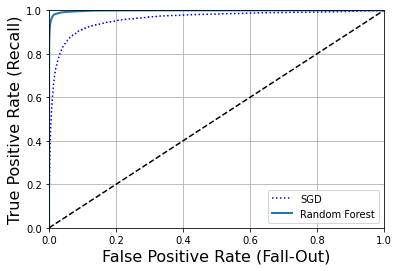

In [38]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

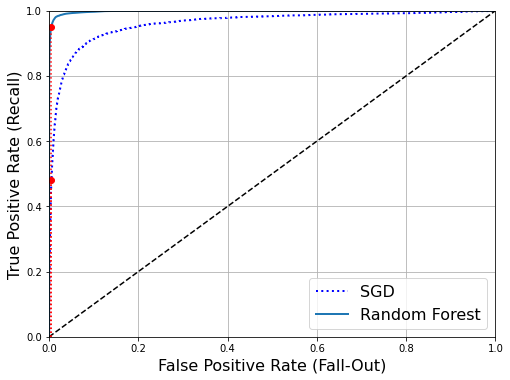

In [39]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)

plt.show()

 &rarr; RandomForestClassifier의 ROC 곡선이 왼쪽 위 모서리에 더 가까워 SGDClassifier보다 훨씬 좋아 보임. 당연하게 ROC AUC 점수도 훨씬 높음.

In [42]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

 &rarr; 정밀도와 재현율 점수를 계산하면 99.0% 정밀도와 86.6% 재현율이 나옴.

## **3.4 다중 분류**

- 이진 분류가 두 개의 클래스를 구별하는 반면 다중 분류기(multiclass classifier(또는 다항 분류기)) 둘 이상의 클래스를 구별할 수 있음.
- 일부 알고리즘(ex. SGD 분류기, 랜덤 포레스트 분류기, 나이브 베이즈 분류기)은 여러 개의 클래스를 직접 처리할 수 있는 반면, 다른 알고리즘(ex. 로지스틱 회귀나 서포트 벡터 머신 분류기)는 이진 분류만 가능함.
- 하지만 이진 분류기를 여러 개 사용해 다중 클래스를 분류하는 기법도 많음.
- **OvR**(one-versus-the-rest) 전략 또는 **OvA**(one-versus-all): 이미지를 분류할 때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택
- **OvO**(one-versus-one): 0과 1 구별, 0과 2 구별, 1과 2 구별 등과 같이 각 숫자의 조합마다 이진 분류기를 훈련시키는 것
    - 클래스가 N개라면 분류기는 N*(N-1)/2개가 필요함.
    - MNIST 문제에서는 45개의 분류기를 훈련시켜야 하므로, 이미지 하나를 분류하려면 45개 분류기 모두를 통과시켜서 가장 많이 양성으로 분류된 클래스를 선택함.
    - OvO 전략의 주요 장점은 각 분류기의 훈련에 전체 훈련 세트 중 두 클래스에 해당하는 샘플만 필요하다는 것임.
- 일부 알고리즘(ex. 서포트 벡터 머신)은 훈련 세트의 크기에 민감해서 큰 훈련 세트에서 몇 개의 분류기를 훈련시키는 것보다 작은 훈련 세트에서 많은 분류기를 훈련시키는 쪽이 빠르므로 OvO를 선호함. 하지만 대부분의 이진 분류 알고리즘에서는 OvR을 선호함.
- 다중 클래스 분류 작업에 이진 분류 알고리즘을 선택하면 사이킷런이 알고리즘에 따라 자동으로 OvR 또는 OvO를 실행함.


In [44]:
from sklearn.svm import SVC
svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train_5이 아니라 y_train을 사용
svm_clf.predict([some_digit])

array([5], dtype=uint8)

 &rarr; 5를 구별한 타깃 클래스(y_train_5) 대신 0에서 9까지의 원래 타깃 클래스(y_train)를 사용해 SVC를 훈련시킨 다음, 예측 하나를 만든 것임.  
 &rarr; 내부에서는 사이킷런이 OvO 전략을 사용해 10개의 이진 분류기를 훈련시키고 각각의 결정 점수를 얻어 점수가 가장 높은 클래스를 선택함.
- `decision_function()` 메서드를 호출하면 (1개가 아니라) 샘플 당 10개의 점수를 반환함. 이 점수는 클래스마다 하나씩임.

In [45]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

 &rarr; 가장 높은 점수가 클래스 5에 해당하는 값임.

In [46]:
np.argmax(some_digit_scores)

5

In [47]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [48]:
svm_clf.classes_[5]

5

- 사이킷런에서 OvO나 OvR을 사용하도록 강제하려면 OneVsOneClassifier나 OneVsRestClassifier를 사용함.
    - 간단하게 이진 분류기 인스턴스를 만들어 객체를 생성할 때 전달하면 됨.  
    (심지어 이진 분류기일 필요도 없음).

In [49]:
# SVC 기반으로 OvR 전략을 사용하는 다중 분류기 만들기
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [50]:
len(ovr_clf.estimators_)

10

- SGDClassifier(또는 RandomForestClassifier)를 훈련시키는 것도 간단함.

In [51]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

- 이 경우 SGD 분류기는 직접 샘플을 다중 클래스로 분류할 수 있기 때문에 별도로 사이킷런의 OvR이나 OvO를 적용할 필요가 없음.
- SGD 분류기가 클래스마다 부여한 점수를 확인해보기
    - `decision_function()` 메서드는 클래스마다 하나의 값을 반환함.

In [52]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

 &rarr; 이 결과에서 분류기가 예측 결과에 강한 확신을 보이고 있음을 알 수 있음.  
 &rarr; 대부분의 점수가 큰 음수임. 반면 클래스 5의 점수는 1823.7임.
- 분류기 평가에는 일반적으로 교차 검증을 사용함.
- `cross_val_score()` 함수를 사용해 SGDClassifier의 정확도 평가

In [53]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

 &rarr; 모든 테스트 폴드에서 84% 이상을 얻음.  
 &rarr; 랜덤 분류기를 사용했다면 10% 정확도를 얻었을 것이므로 이 점수가 아주 나쁘지는 않지만 성능을 더 높일 여지가 있음.

In [55]:
# 입력의 스케일을 조정하여 성능 높이기
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## **3.5 에러 분석**

- 실제 프로젝트라면 머신러닝 프로젝트 체크리스트의 단계를 따를 것임.
    - 데이터 준비 단계에서 가능한 선택 사항을 탐색하고, 여러 모델을 시도하고, 가장 좋은 몇 개를 골라 GridSearchCV를 사용해 하이퍼파라미터를 세밀하게 튜닝하고, 앞 장에서 한 것처럼 가능한 한 자동화함.
- 이 절에서는 가능성이 높은 모델을 하나 찾았다고 가정하고 이 모델의 성능을 향상시킬 방법을 찾아보고자 함.
- 한 가지 방법은 만들어진 에러의 종류를 분석하는 것임.

<U>오차 행렬 살펴보기</U>
- `cross_val_predict()` 함수를 사용해 예측을 만들고 이전처럼 `confusion_matrix()` 함수를 호출함.



In [56]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

- 오차 행렬을 맷플롯립의 `matshow()` 함수를 사용해 이미지로 표현하면 보기에 편리할 때가 많음.

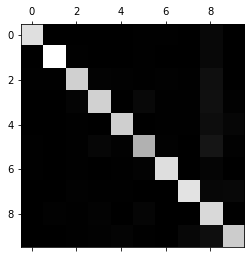

In [57]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

 &rarr; 이 오차 행렬은 대부분의 이미지가 올바르게 분류되었음을 나타내는 주대각선에 있으므로 매우 좋아 보임.
 &rarr; 숫자 5는 다른 숫자보다 조금 더 어두워 보임. 이는 데이터셋에 숫자 5의 이미지가 적거나 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 뜻임. 사실 두 경우에 대해 모두 확인해 봐야 함.

그래프의 에러 부분에 초점 맞춰보기
- 오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어(에러의 절대 개수가 아니라) 에러 비율을 비교함.

In [58]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

- 다른 항목은 그대로 유지하고 주대각선만 0으로 채워서 그래프를 그림.

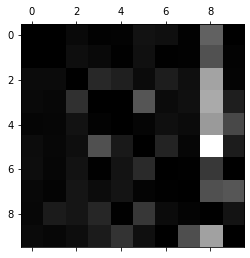

In [59]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

 &rarr; 분류기가 만든 에러를 확실히 볼 수 있음. 행은 실제 클래스를 나타내고 열은 예측한 클래스를 나타낸다는 사실을 기억해야 함.  
 &rarr; 클래스 8이 열이 상당히 밝으므로 많은 이미지가 8로 잘못 분류되었음을 암시함. 하지만 클래스 8의 행은 그리 나쁘지 않음. 이는 실제 8이 적절히 8로 분류되었다는 것을 말해줌.  
 &rarr; 여기서 볼 수 있듯이 오차 행렬은 반드시 대칭인 것은 아님. 3과 5가 (서로) 많이 혼동되고 있는 것도 볼 수 있음.

- 오차 행렬을 분석하면 분류기의 성능 향상 방안에 대한 통찰을 얻을 수 있음.
    - 이 그래프를 살펴보면 8로 잘못 분류되는 것을 줄이도록 개선할 필요가 있음.
        - 예) 8처럼 보이는 (하지만 실제 8은 아닌) 숫자의 훈련 데이터를 더 많이 모아서 실제 8과 구분하도록 분류기를 학습시킬 수 있음.
        - 예) 분류기에 도움 될 만한 특성을 더 찾아볼 수 있음.
        - 예) 동심원 같은 어떤 패턴이 나도록 (Scikit-Image, Pillow, OpenCV 등을 사용해서) 이미지를 전처리해볼 수 있음.
- 개개의 에러를 분석해보면 분류기가 무슨 일을 하고, 왜 잘못되었는지에 대해 통찰을 얻을 수 있지만, 더 어렵고 시간이 오래 걸림.

*3과 5의 샘플을 그려보기*

In [61]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다. 
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

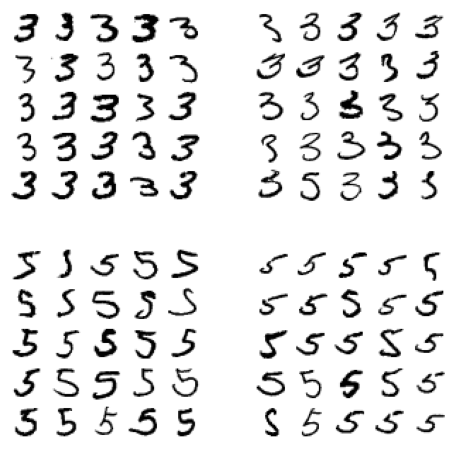

In [62]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

- 왼쪽의 5*5 블록 두 개는 3으로 분류된 이미지이고 오른쪽 5*5 블록 두 개는 5로 분류된 이미지임.
- 분류기가 잘못 분류한 숫자 중 일부는 정말 잘못 쓰여 있어서(왼쪽 아래 블록과 오른쪽 위 블록) 사람도 분류하기 어려울 것임.
- 그러나 대부분의 잘못 분류된 이미지는 확실히 에러인 것 같고 분류기가 실수한 이유를 이해하기 어려움. 원인은 선형 모델인 SGDClassifier를 사용했기 때문임.
    - 선형 분류기는 클래스마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산함. 따라서 3과 5는 몇 개의 픽셀만 다르기 때문에 모델이 쉽게 혼동하게 됨.
- 3과 5의 주요 차이는 위쪽 선과 아래쪽 호를 이어주는 작은 직선의 위치임.
    - 숫자 3을 쓸 때 연결 부위가 조금 왼쪽으로 치우치면 분류기가 5로 분류하고, 또 반대로 마찬가지임. 다른 말로 하면 분류기는 이미지의 위치나 회전 방향에 매우 민감함.
- 3과 5의 에러를 줄이는 한 가지 방법은 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리하는 것임. 이렇게 하면 아마 다른 에러도 줄어들 것임.



## **3.6 다중 레이블 분류**

- 지금까지는 각 샘플이 하나의 클래스에만 할당되었지만, 분류기가 샘플마다 여러 개의 클래스를 출력해야 할 때도 있음.
- **다중 레이블 분류**(multilabel classification) 시스템: 여러 개의 이진 꼬리표를 출력하는 분류 시스템


In [63]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

 &rarr; 각 숫자 이미지에 두 개의 타깃 레이블이 담긴 y_multilabel 배열을 만듦.  
 &rarr; 첫 번째는 숫자가 큰 값(7,8,9)인지 나타내고 두 번째는 홀수인지 나타냄.  
 &rarr; 그다음 줄이 KNeighborClassifier 인스턴스를 만들고 다중 타깃 배열을 사용하여 훈련시킴.

In [64]:
knn_clf.predict([some_digit])

array([[False,  True]])

- 다중 레이블 분류기를 평가하는 방법은 많음.
- 적절한 지표는 프로젝트에 따라 다름.
    - 예) 각 레이블 F1 점수를 구하고 간단하게 평균 점수를 계산

In [65]:
# 모든 레이블에 대한 F1 점수의 평균 계산
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

 &rarr; 실제로는 아닐 수 있지만 이 코드는 모든 레이블의 가중치가 같다고 가정한 것임.

- 레이블에 클래스의 지지도(즉, 타깃 레이블에 속한 샘플 수)를 가중치로 주어 가중치를 다르게 둘 수 있음. - `average="weighted"`




## **3.7 다중 출력 분류**

- 다중 출력 다중 클래스 분류(multioutput-multiclass classification(또는 간단히 다중 출력 분류)): 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것(즉, 값을 두 개 이상 가질 수 있음)  

- 이를 위해 이미지에서 잡음을 제거하는 시스템을 만들어보기
    - 잡음이 많은 숫자 이미지를 입력으로 받고 (기대하건대) 깨끗한 숫자 이미지를 MNIST 이미지처럼 픽셀의 강도를 담은 배열로 출력함.
    - 분류기의 출력이 다중 레이블(픽셀당 한 레이블)이고 각 레이블은 값을 여러 개 가짐(0부터 255까지 픽셀 강도).
- 먼저 MNIST 이미지에서 추출한 훈련 세트와 테스트 세트에 넘파이의 `radint()` 함수를 사용하여 픽셀 강도에 잡음을 추가함. 타깃 이미지는 원본 이미지가 될 것임.

In [66]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

- 테스트 세트에서 이미지를 하나 선택함.
- 분류기를 훈련시켜 이미지를 깨끗하게 만들어보기

In [70]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [71]:
some_index = 0

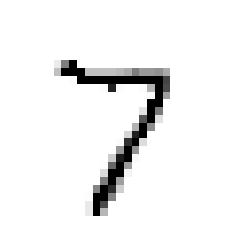

In [72]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)